# End-to-End framework: from original DF to DF with embs and labels

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
plt.rcParams["figure.figsize"] = [20,10]
from NetEmbs import *
d = upload_data("Simulation/FSN_Data.db", limit=300)
d.head(4)

In [3]:
from NetEmbs.DataProcessing import *
journal_entries = None
if journal_entries is None:
    d = prepare_data(d)
else:
    YOUR_DATAFRAME = pd.DataFrame.from_dict(journal_entries)
    YOUR_DATAFRAME.columns = ['ID', 'FA_Name', 'Debit', 'Credit']
    d = prepare_data(YOUR_DATAFRAME, split=False)
d.head(4)

,ID,Signature,FA_Name,Debit,Credit,from
0,2,"([('Revenue', 0.94356), ('Tax', 0.05644)], [('...",Revenue,0.000000,0.943562,True
1,2,"([('Revenue', 0.94356), ('Tax', 0.05644)], [('...",Tax,0.000000,0.056438,True
2,2,"([('Revenue', 0.94356), ('Tax', 0.05644)], [('...",TradeReceivables,0.990561,0.000000,False
3,2,"([('Revenue', 0.94356), ('Tax', 0.05644)], [('...",aofere,0.001368,0.000000,False


In [ ]:
from NetEmbs.Vis.plots import plotFSN
plotFSN(d, edge_labels=False, node_labels=False)

## TensorFlow

In [ ]:
from NetEmbs.SkipGram import *

In [ ]:
res = add_ground_truth(get_embs_TF(d, embed_size=6, num_steps=50000, walk_length=20,
                walks_per_node=100), "Simulation/FSN_Data.db")

In [ ]:
import seaborn as sns
for name, group in res.groupby("GroundTruth"):
    print(name)
    if group.shape[0] > 3:
        sns.heatmap(list(group["Emb"].values), vmin=-1.0, vmax=1.0, cmap=sns.color_palette("RdBu_r", 16))
        plt.show()
    else:
        print("Not enough samples...")

In [ ]:
from NetEmbs.Vis import *
set_font()
plot_tSNE(res, title="Good_tSNE")

In [4]:
res = pd.read_pickle("tmp_embs.pkl")

In [5]:
res.head(4)

,ID,Emb,FA_Name
0,2,"[-0.51590633, 0.44843608, -0.6765839, 0.172856...",Sales 6 btw
1,3,"[-0.09579003, 0.25433877, 0.6123743, 0.5961645...",Cost of Sales
2,4,"[-0.6812292, -0.38854262, 0.38754085, -0.32557...",Fixed Assets
3,5,"[-0.28037363, -0.023306053, -0.6254437, -0.546...",Sales 6 btw


## KMeans vs. Ground truth

First row of Data: 
 [-0.51590633  0.44843608 -0.67658389  0.17285612 -0.11130223  0.18086587]


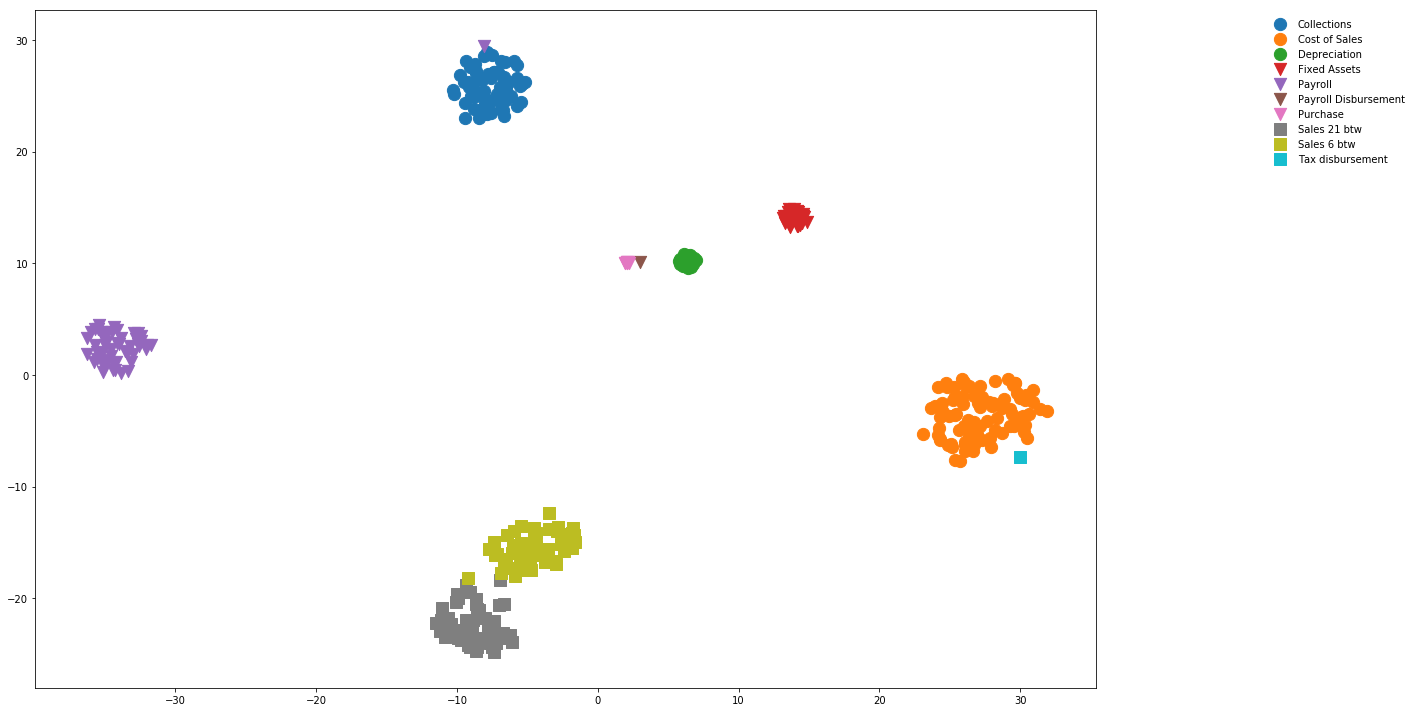

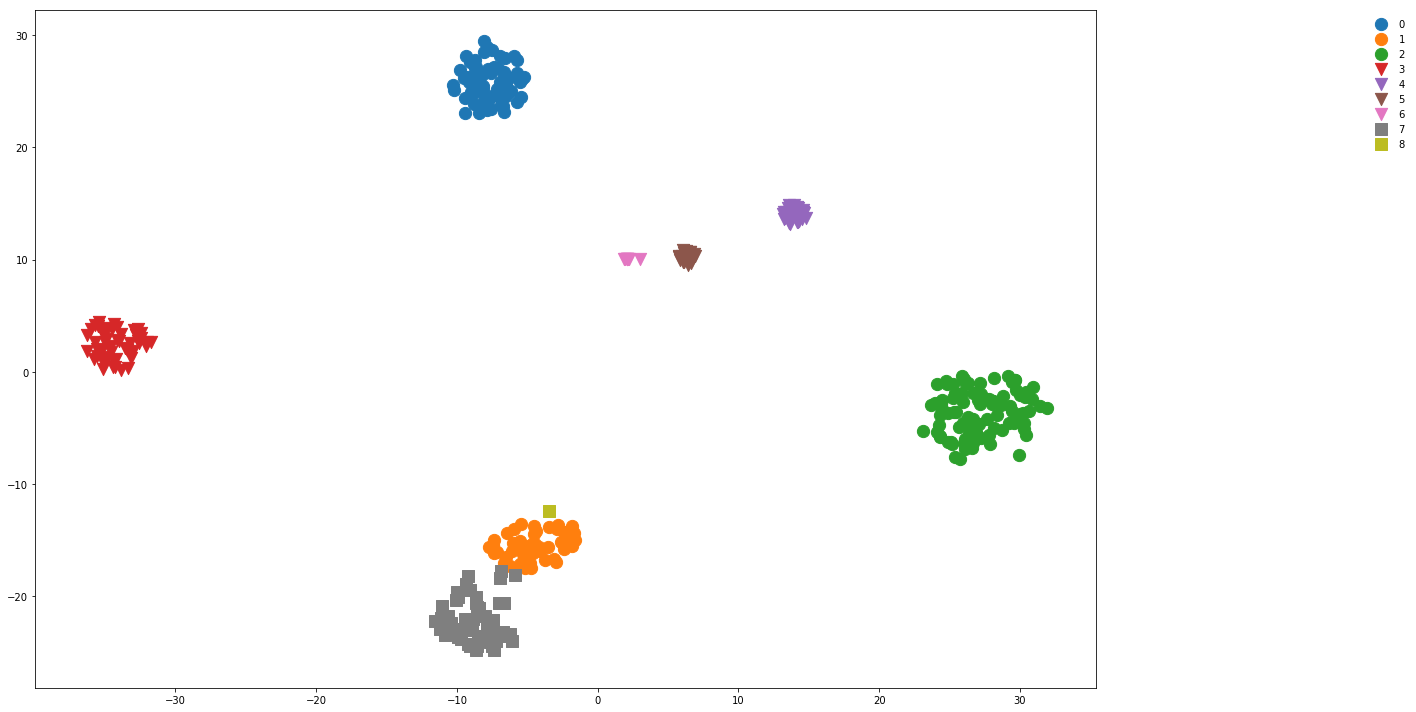

In [7]:
from NetEmbs.Clustering import *
cl_labs = cl_KMeans(res, 9)
from NetEmbs.Vis.plots import plot_tSNE
plot_tSNE(cl_labs, legend_title="FA_Name")
plot_tSNE(cl_labs, legend_title="label")

## Agglomerative vs. Ground truth

First row of Data: 
 [-0.51590633  0.44843608 -0.67658389  0.17285612 -0.11130223  0.18086587]


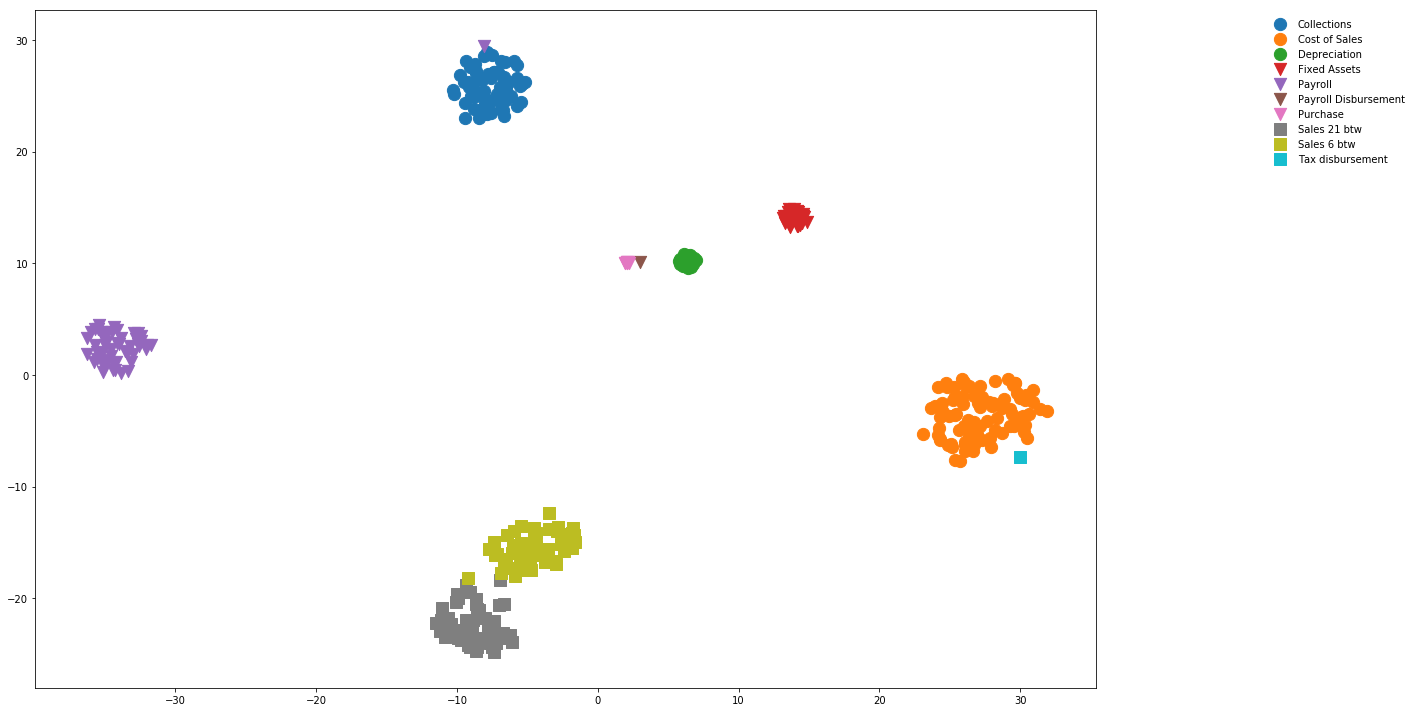

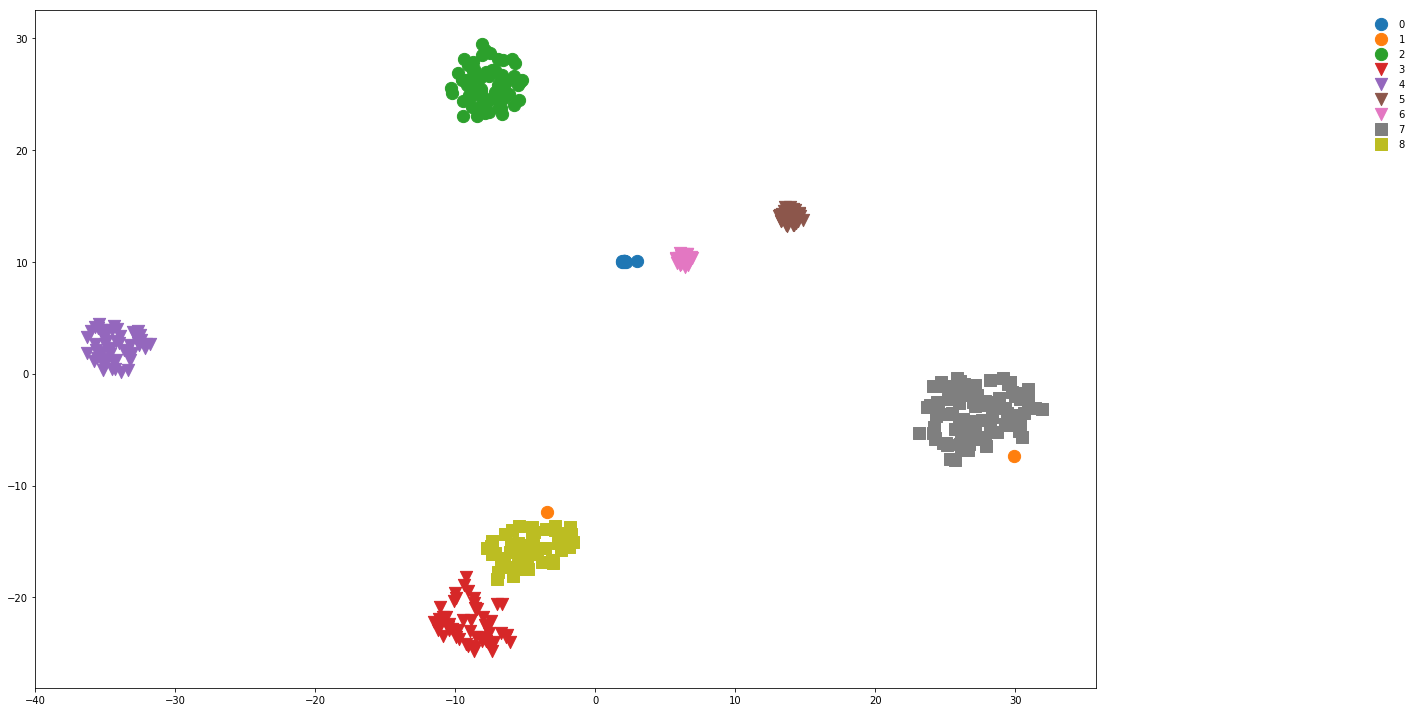

In [8]:
from NetEmbs.Clustering import *
cl_labs = cl_Agglomerative(res, 9)
from NetEmbs.Vis.plots import plot_tSNE
plot_tSNE(cl_labs, legend_title="FA_Name")
plot_tSNE(cl_labs, legend_title="label")

# Observations

Although during the proof of concept phase we'd shown that business processes of the same type but with different parameters are separated in terms of joint appearance, in embedding space one cannot see a bold border between them. The possible explanation of it could be the chosen window size (def. window size is 3 what means 3 nodes in sampled sequences before and three after) AND the transition probability for the first sub-step which depends only on the monetary flow. As a result, one gets mixed pairs (taxRate1->taxRate2->taxRate1->etc.) and feeding them into Skip-Gram model returns unclear border.

It could be overcome by using longer randomWalks and a higher number of samplings. Or, another possible solution, is to double each step: (taxRate10->taxRate11)->taxRate20 becomes (taxRate10->taxRate11->taxRate10->taxRate11)->taxRate20 what leads to the higher joint appearance of inner-similar BPs.

## WordsCloud

In [9]:
cl_labs = cl_labs.rename(index=str, columns={"FA_Name": "GroundTruth"})
cl_labs.head()

,ID,Emb,GroundTruth,label,x,y
0,2,"[-0.51590633, 0.44843608, -0.6765839, 0.172856...",Sales 6 btw,1,-3.456999,-12.401495
1,3,"[-0.09579003, 0.25433877, 0.6123743, 0.5961645...",Cost of Sales,7,25.990494,-4.564216
2,4,"[-0.6812292, -0.38854262, 0.38754085, -0.32557...",Fixed Assets,5,14.828806,13.731114
3,5,"[-0.28037363, -0.023306053, -0.6254437, -0.546...",Sales 6 btw,8,-5.847455,-18.049055
4,6,"[-0.028355801, 0.22884594, 0.7344476, 0.467523...",Cost of Sales,7,30.648798,-3.473578


In [10]:
w_cnt = d.merge(cl_labs, on="ID")

In [23]:
from collections import Counter
from itertools import dropwhile
def get_top_FAs(df, more_than=5):
    cnt = Counter(df['FA_Name'].values)
    for key, count in dropwhile(lambda key_count: key_count[1] >= more_than, cnt.most_common()):
        del cnt[key]
    return cnt

In [41]:
w_cnt.groupby("label", as_index=False).apply(get_top_FAs).values

array([Counter({'OtherExpenses': 9, 'PersonnelExpenses': 9, 'PrepaidExpenses': 9, 'TradePayables': 9}),
       Counter(), Counter({'Cash': 62, 'TradeReceivables': 62}),
       Counter({'Revenue': 52, 'Tax': 52, 'TradeReceivables': 52}),
       Counter({'EBPayables': 49, 'PersonnelExpenses': 49, 'Tax': 49}),
       Counter({'FixedAssets': 25, 'TradePayables': 25}),
       Counter({'DepreciationExpense': 19, 'FixedAssets': 19}),
       Counter({'CostOfSales': 90, 'Inventory': 90}),
       Counter({'Revenue': 56, 'Tax': 56, 'TradeReceivables': 56})],
      dtype=object)

In [ ]:
text = {"Left": Counter(w_cnt.head(100)[group["from"] == True]["FA_Name"].values), 
               "Right": Counter(group[group["from"] == False]["FA_Name"].values)}

Current cluster label is  0
[('OtherExpenses', 9), ('PersonnelExpenses', 9), ('PrepaidExpenses', 9), ('Cash', 1), ('afguko', 1)]
[('TradePayables', 9), ('EBPayables', 1), ('gwoszl', 1), ('gwvxyc', 1), ('hdenqz', 1)]


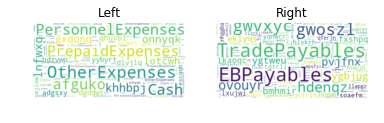

Current cluster label is  1
[('Revenue', 1), ('Tax', 1), ('Cash', 1)]
[('TradeReceivables', 1), ('aofere', 1), ('dtnasn', 1), ('freafi', 1), ('ixsros', 1)]


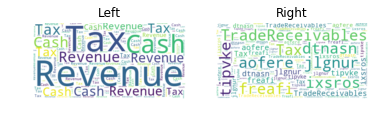

Current cluster label is  2
[('TradeReceivables', 62), ('aofere', 1), ('dtnasn', 1), ('freafi', 1), ('ixsros', 1)]
[('Cash', 62), ('fifbep', 1), ('rvyuhv', 1), ('utqiuo', 1)]


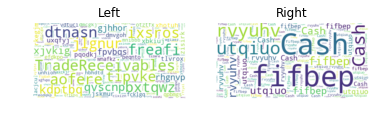

Current cluster label is  3
[('Revenue', 52), ('Tax', 52), ('fujvdr', 1), ('refmmh', 1), ('abbipl', 1)]
[('TradeReceivables', 52), ('gjhhor', 1), ('fpvbqs', 1), ('rhgnvp', 1), ('uxqfyj', 1)]


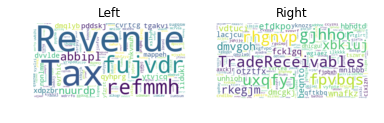

Current cluster label is  4
[('EBPayables', 49), ('Tax', 49), ('arzjdv', 1), ('iqvfaf', 1), ('buveui', 1)]
[('PersonnelExpenses', 49), ('actonk', 1), ('ckkjqv', 1), ('crtdgp', 1), ('gibnvq', 1)]


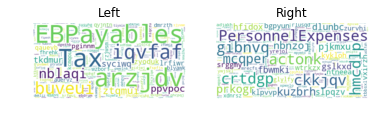

Current cluster label is  5
[('TradePayables', 25), ('hfjjrg', 1), ('mfnhby', 1), ('myscyz', 1), ('qoftkk', 1)]
[('FixedAssets', 25), ('mkiqye', 1), ('pmcvyz', 1), ('rfevag', 1), ('thummq', 1)]


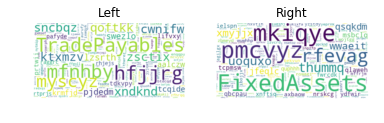

Current cluster label is  6
[('FixedAssets', 19), ('wgxigp', 1), ('zzypsq', 1), ('aysjjg', 1), ('qgkgor', 1)]
[('DepreciationExpense', 19), ('ohqvsi', 1), ('rpweip', 1), ('mdusvc', 1), ('nyknud', 1)]


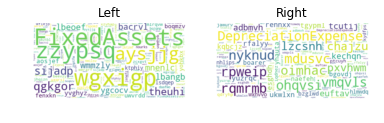

Current cluster label is  7
[('Inventory', 90), ('hupiwv', 1), ('irnymx', 1), ('reyzwj', 1), ('edohio', 1)]
[('CostOfSales', 90), ('lswkze', 1), ('mlmrie', 1), ('nzdzyf', 1), ('rcfnmn', 1)]


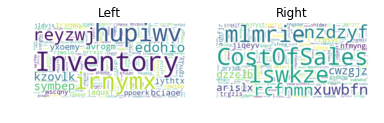

Current cluster label is  8
[('Revenue', 56), ('Tax', 56), ('epvwqs', 1), ('jkkbmp', 1), ('ruxrek', 1)]
[('TradeReceivables', 56), ('bxtqwz', 1), ('kdptbq', 1), ('qvscnp', 1), ('xjvkig', 1)]


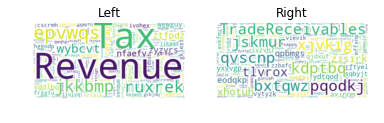

In [50]:
from wordcloud import WordCloud
wc = WordCloud(background_color="white", repeat=True)
for name, group in w_cnt.groupby("label"):
    print("Current cluster label is ", name)
    text = {"Left": Counter(group[group["from"] == True]["FA_Name"].values), 
               "Right": Counter(group[group["from"] == False]["FA_Name"].values)}
    i = 1
    fig = plt.figure()
    for key, data in text.items():
        ax = fig.add_subplot(1,2,i)
        i+=1
        print(data.most_common(5))
        ax.set_title(key)
        wc = WordCloud(background_color="white", repeat=True)
        wc.generate_from_frequencies(data)
        ax.axis("off")
        ax.imshow(wc, interpolation="bilinear")
    plt.show()

Current cluster label is  0


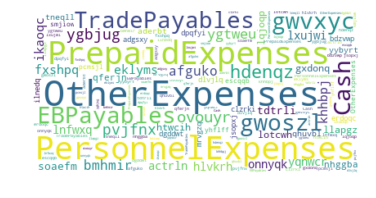

Current cluster label is  1


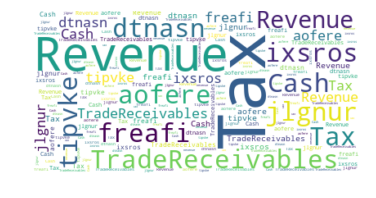

Current cluster label is  2


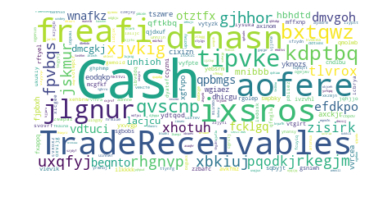

Current cluster label is  3


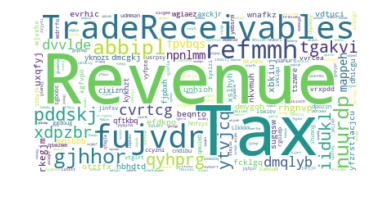

Current cluster label is  4


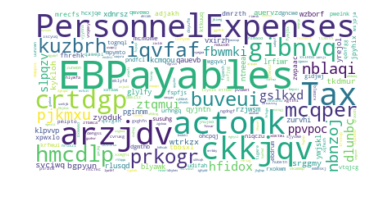

Current cluster label is  5


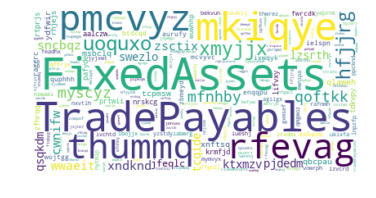

Current cluster label is  6


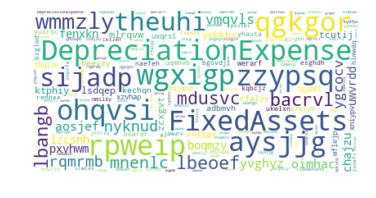

Current cluster label is  7


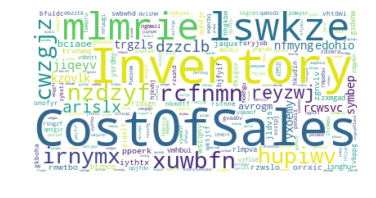

Current cluster label is  8


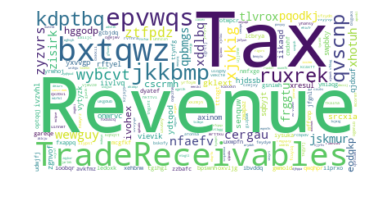

In [43]:
from wordcloud import WordCloud
wc = WordCloud(background_color="white", repeat=True)
for name, group in w_cnt.groupby("label"):
    print("Current cluster label is ", name)
    text = Counter(group["FA_Name"].values)
    wc = WordCloud(background_color="white", repeat=True)
    wc.generate_from_frequencies(text)
    plt.axis("off")
    plt.rcParams["figure.figsize"] = [6,3]
    plt.imshow(wc, interpolation="bilinear")
    plt.show()